# Image Segmentation Example

In this notebook, we explore basic image segmentation techniques using OpenCV. We'll demonstrate **thresholding** and **contour detection** to segment simple images, use the **watershed algorithm** to separate touching objects, and apply **GrabCut** for foreground-background segmentation. We will use example images from scikit-image's data module. (See the https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html for more context.)


In [1]:
# Install required libraries (uncomment if needed)
!pip install opencv-python scikit-image

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 4.3 MB/s eta 0:00:00a 0:00:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 kB 3.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
%matplotlib inline

## Example 1: Simple Thresholding and Contour Detection

We'll use an example image of coins (from scikit-image) which is grayscale. Our goal is to separate the coins from the background. First, we apply binary thresholding to create a binary image, then use `findContours` to detect object boundaries.

(303, 384) uint8


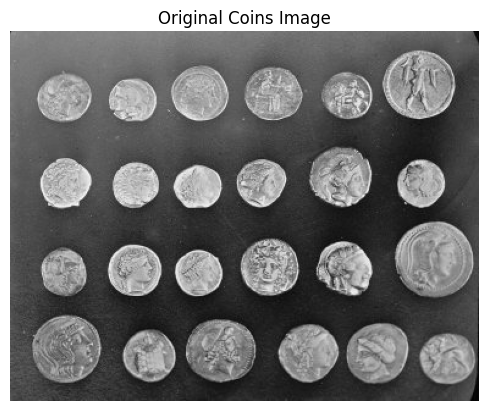

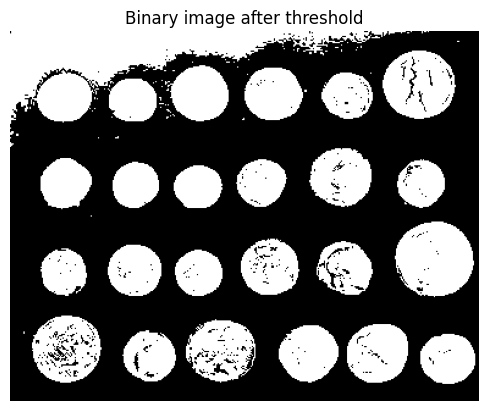

In [3]:
# Load example image (coins)
coins = data.coins()  # grayscale image of coins
print(coins.shape, coins.dtype)
plt.imshow(coins, cmap='gray')
plt.title('Original Coins Image')
plt.axis('off')
plt.show()

# Threshold the image using Otsu's method
_, coins_bin = cv2.threshold(coins, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(coins_bin, cmap='gray')
plt.title('Binary image after threshold')
plt.axis('off')
plt.show()

After thresholding, we have a binary image where coins are white and background is black. Now, let's find contours in this binary image. Each contour corresponds to the outline of a connected component (one or more coins).

Number of contours found: 96


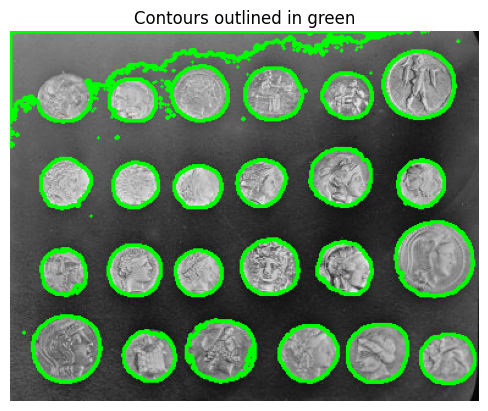

In [4]:
# Find contours of the coins
contours, hierarchy = cv2.findContours(coins_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

# Draw contours on a copy of the original image
coins_color = cv2.cvtColor(coins, cv2.COLOR_GRAY2BGR)
cv2.drawContours(coins_color, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(coins_color, cv2.COLOR_BGR2RGB))
plt.title('Contours outlined in green')
plt.axis('off')
plt.show()

We found contours, but notice that touching coins are detected as one contour. Next, we'll use the **watershed** algorithm to split those connected coins. Watershed treats the binary image like a topographic surface and separates regions at 'watershed lines'.

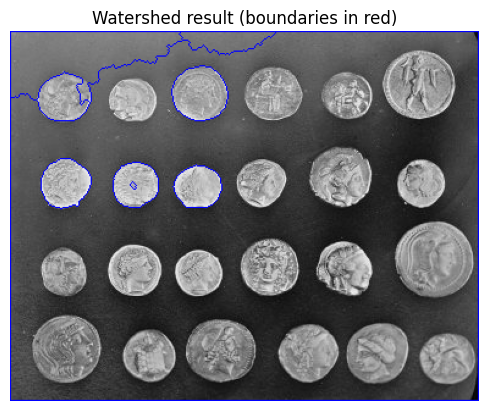

In [5]:
# Watershed segmentation to separate connected objects

# Step 1: Noise removal via morphological opening
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(coins_bin, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 2: Sure background area by dilation
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Step 3: Sure foreground area by distance transform
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Step 4: Identify unknown region (which is neither sure foreground nor background)
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 5: Label the sure foreground regions
num_labels, markers = cv2.connectedComponents(sure_fg)

# Step 6: Add one to marker labels so that sure background is not 0
markers = markers + 1
# Mark the unknown region with zero
markers[unknown == 255] = 0

# Step 7: Apply watershed
coins_color2 = cv2.cvtColor(coins, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(coins_color2, markers)
coins_color2[markers == -1] = [255, 0, 0]  # mark watershed boundaries in red

plt.imshow(cv2.cvtColor(coins_color2, cv2.COLOR_BGR2RGB))
plt.title('Watershed result (boundaries in red)')
plt.axis('off')
plt.show()

The watershed algorithm has separated the touching coins (red lines highlight the boundaries between coins). Each coin should now be an individual segmented region.

## Example 2: GrabCut Foreground Extraction

Now let's use a color image and apply GrabCut to extract the main subject from the background. We'll use an example image of a cat. GrabCut requires an initial guess, which we provide as a rectangle containing the foreground object.

(300, 451, 3)


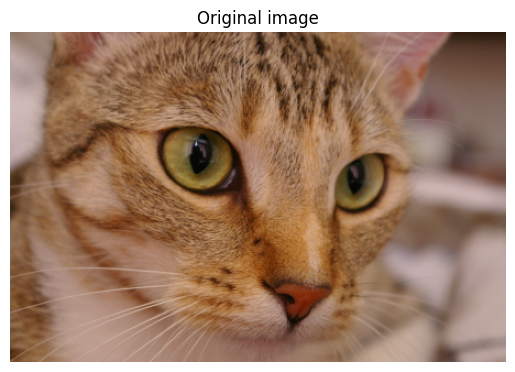

Using rectangle for GrabCut: (45, 30, 360, 240)


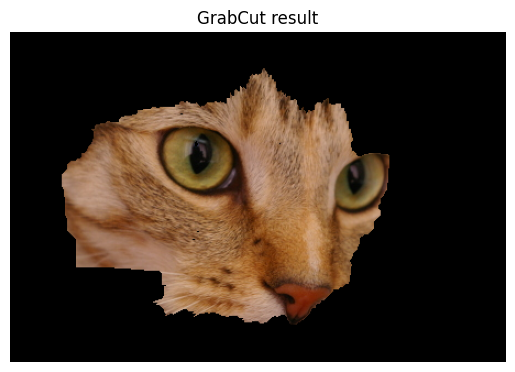

In [6]:
# Load example color image (cat)
image = data.chelsea()  # Chelsea the cat image
print(image.shape)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.show()

# Initialize mask and models for GrabCut
mask = np.zeros(image.shape[:2], np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# Define a bounding box around the cat (x, y, width, height)
h, w = image.shape[0], image.shape[1]
rect = (int(w*0.1), int(h*0.1), int(w*0.8), int(h*0.8))
print("Using rectangle for GrabCut:", rect)

# Apply GrabCut
cv2.grabCut(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Prepare mask: pixels set to 1 or 0 for foreground/background
mask2 = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
result = image * mask2[:, :, np.newaxis]

plt.imshow(result)
plt.title('GrabCut result')
plt.axis('off')
plt.show()

The GrabCut result shows the foreground (the cat) separated from the background (now black). We started with a rectangle to initialize GrabCut; it then refines the segmentation. You could further improve the result by marking certain areas as definite foreground/background if needed (GrabCut can take user-editing input as masks).

---
These examples illustrate basic segmentation techniques with OpenCV. For more complex images or advanced needs, deep learning methods (like U-Net or Mask R-CNN) can be used, but they require training data and are beyond the scope of this introductory exercise.